In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, morphology, measure
import nibabel as nib
from scipy import ndimage, spatial
import cv2

In [2]:
# ASSUMING HD-BET IS DONE ON THE IMAGES : swi_bet.nii.gz and swi_bet_mask.nii.gz must be present
dat_dir = "/Workspace/Data/"
all_dir = os.listdir(dat_dir)
all_dir = [all_dir[i] if all_dir[i].isdigit() else all_dir.pop(i) for i in range(len(all_dir))]
all_dir = [os.path.join(dat_dir, patient) for patient in all_dir]

In [3]:
for i, dir in enumerate(all_dir):
    if len(os.listdir(dir)) > 2:
        print(f'{i} in  {dir}')
        print(os.listdir(dir))

40 in  /Workspace/Data/21113002
['swi_bet.nii.gz', 'swi_bet_mask.nii.gz', 'swi.nii.gz', 'cmb.nii.gz']


In [10]:
swi_bet = io.imread(os.path.join(all_dir[40], "swi_bet.nii.gz"), plugin="simpleitk")
#1s in the mask are brain region.
bet_mask = io.imread(os.path.join(all_dir[40], "swi_bet_mask.nii.gz"), plugin="simpleitk")
background = np.logical_not(bet_mask)

In [16]:
strip_slice = swi_bet[40]
mask_slice = bet_mask[40]
bg_slice = background[40].astype(np.uint8)

In [62]:
def unsharp_mask(image, kernel_size=(3,3), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image-blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [63]:
sharp = unsharp_mask(strip_slice)

In [96]:
ret, thresh = cv2.threshold(sharp, 127, 255, 0)

In [129]:
param = cv2.SimpleBlobDetector_Params()
param.filterByArea=True
param.minArea=3
param.maxArea=50
param.filterByCircularity=True
param.minCircularity=0.1
param.maxCircularity=1.0
param.minDistBetweenBlobs=1
param.minRepeatability=1

detector = cv2.SimpleBlobDetector_create(param)
points = detector.detect(thresh.astype(np.uint8))
## this is all we need for cmb hunt. but go on further for submission to the prof

In [134]:
blob_mask = np.zeros_like(sharp, dtype=np.uint8)

In [159]:
kp = cv2.drawKeypoints(thresh.astype(np.uint8), points, blob_mask, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

In [164]:
nifti = nib.Nifti1Image(blob_mask, affine=np.eye(4))
nib.save(nifti, '/Workspace/Data/21113002/cmb_candidate.nii.gz')

<hr style="color:red">
BELOW ARE TEST CODES
<hr>

In [266]:
threshold = filters.threshold_otsu(strip_slice)
bin_mask = swi_bet[40] < threshold

In [ ]:
res = bin_mask.astype(int) - bet_bg[40]

In [361]:
# that fills very tiny holes. that's good
fin = ndimage.binary_fill_holes(res)

In [362]:
contours, _ = cv2.findContours(fin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [377]:
contours[0]

array([[[191, 296]],

       [[192, 296]]], dtype=int32)

In [375]:
mask = np.zeros_like(fin, dtype=np.uint8)
fin2 = cv2.drawContours(mask, contours, -1, 1, thickness=cv2.FILLED)


/opt/conda/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


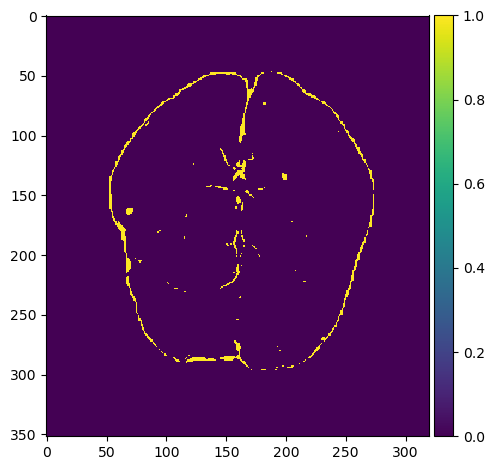

In [376]:
io.imshow(fin2)

In [170]:
mark = np.zeros_like(slice)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [171]:
np.unique(mark)

array([0.])